In [4]:
import numpy as np
from esim.utils.plotting import DFT
from esim.utils import plotting 
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
np.random.seed(42)

## Constants \& Circuit Setup Functions

In [80]:
w0 = omega_z = 2*np.pi*300e6
kB = 1.380649e-23
dt = 1e-13
temp_res = 0.4
q  = -1.602177e-19
deff = 1e-3
noise_fact = -q/deff

Q = 1000
C = 1e-12
L = 250e-9
#R = 500e3 # calculated s.t. Rp = Re(Z(w0)) for series-RLC case, altho it seems that this can only happen when R = Rp... see RLCs.ipynb for details
R = 3.26e3 # calculated R that maximizes the Re(Z) for the circuit config used in the cell below, altho this does not get max Re(Z) to desired Rp
Rp = resistance = Q*np.sqrt(L/C)
bandwidth = 1./dt
noise_ampl = np.sqrt(4.*kB*temp_res*resistance*bandwidth)
delta_f = w0/Q

print(f'R: {R:.2e} Ohm, L: {L*1e6:.2f} uH, C: {C*1e9:.2e} nF')
print(f'w0: {w0:.2e}, w0: {1/np.sqrt(L*C):.2e}, Q: {Rp*np.sqrt(C/L)}, Bandwidth: {delta_f:.2e}')

R: 3.26e+03 Ohm, L: 0.25 uH, C: 1.00e-03 nF
w0: 1.88e+09, w0: 2.00e+09, Q: 1000.0, Bandwidth: 1.88e+06


In [53]:
def parallel(a, b):
    return 1/(1/a + 1/b)

def Z(w, R, L, C):
    """
    Return the impedance of the RLC circuit
    """
    s = 1j*w
    #return R + parallel(s*L, 1/(s*C))
    #return parallel(s*L, 1/(s*C)+R)
    return parallel(s*L+R, 1/(s*C))

### Setup $Re(Z)$ and $A(\omega)$

In [54]:
def ReZ(w):
    return Z(w, R, L, C).real

def A(w, DC=False):
    """
    The frequency-dependent amplitude
    """
    if DC:
        w = 0.1
    return np.sqrt(4*kB*temp_res*ReZ(w)*bandwidth) # To be changed

### Sanity Check on $Re(Z)$ and $A(\omega)$

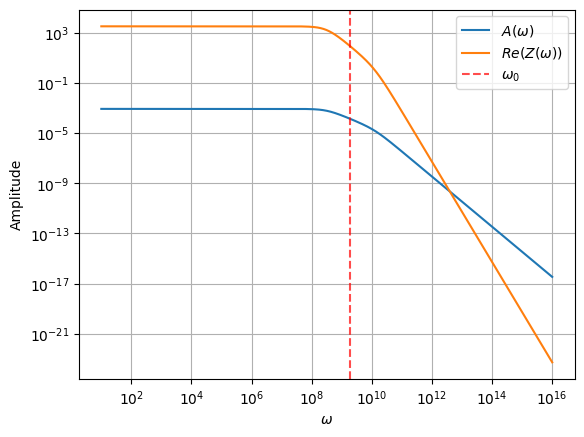

In [57]:
w = 10**np.linspace(1, 16, 100000)

#plt.plot(w, A(w)*1e7)
#plt.plot(w, ReZ(w)*1e-9, '--')
plt.plot(w, A(w), label=r'$A(\omega)$')
plt.plot(w, ReZ(w), label=r'$Re(Z(\omega))$')
plt.axvline(w0, label=r'$\omega_0$', color='r', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.show()

### Setup Noise

In [58]:
def band_limited_noise(center_freqs,bandwidth, samples=1.e6, samplerate=1.e6, DC=False): #samples=10.e4, samplerate=200100):
    """
    Generating band-limited white noise in time domain following the equation
        Noise(t) = sum_w{ A(w) * sin(2*pi*w*t + phase) }
    where the phase is generated randomly and w determined by center frequency
    and bandwidth. Frequencies beyond the range will be cutoff.
    
    Params:
        center_freqs: float
            Center frequency for noise frequency spectrum. A single float number
            in our case for now.
        bandwidth: float
            Bandwidth of the noise. This is somthing I still need to explore, 
            current trials include: w0, w0*10, w0*100, 1/dt.
        samples: int or float
            Number of samples needed in time domain, or number of time steps 
            wanted. This method assumes a non-Markovian noise so the unit of
            time step does not matter as much in this case.
        samplerate: int or float
            Number of samples collected within the time period defined by SAMPLES.
            This should be 1/dt, but note that 1/dt gives a large number.
        DC: bool
            If true, then A(w) = 1 for all w. Default to False.
         
    Returns:
        * Frequencies used to generate the noise
        * FFT frequencies
        * Amplitude of noise in frequency domain
        * Time steps
        * Amplitude of noise in time domain
    """     
    
    ## Generate time steps
    t = np.linspace(0, samples/samplerate, int(samples))
    
    ## Generate frequencies and phases
    min_freq, max_freq = center_freqs-bandwidth/2., center_freqs+bandwidth/2.
    #freqs = np.arange(min_freq, max_freq+1, samples/samplerate) # This is memory-consuming if samplerate is large
    #phases = np.random.rand(len(freqs))*2*np.pi
    #generator = iter(zip(freqs,phases))
    freqs = [] # Empty holder bc recording all freqs is too memory-consuming
    step_size = samples/samplerate
    
    ## Generate signal
    signal=np.zeros(len(t))
    progress_bar = tqdm(total=max_freq-min_freq, position=0, leave=True)
    
    freq = min_freq
    while freq <= max_freq:
        phase = np.random.rand() * 2*np.pi
        #freq, phase = next(generator)
        signal += A(freq, DC=DC) * np.sin(2*np.pi*freq*t + phase)
        freq += step_size
        progress_bar.update(step_size)
        
    progress_bar.close()
    
    ## Return the results
    x=signal
    X = np.fft.fft(x)
    N = len(X)
    
    return freqs, np.fft.fftfreq(N)*samplerate, X, t, signal

In [78]:
def band_limited_noise_sampled(center_freqs,bandwidth, samples=1.e6, samplerate=1.e6, DC=False, n_freq=1e6): #samples=10.e4, samplerate=200100):
    """
    Generating band-limited white noise in time domain following the equation
        Noise(t) = sum_w{ A(w) * sin(2*pi*w*t + phase) }
    where the phase is generated randomly and w determined by center frequency
    and bandwidth. Frequencies beyond the range will be cutoff. w is sampled
    in the frequency range.
    
    Params:
        center_freqs: float
            Center frequency for noise frequency spectrum. A single float number
            in our case for now.
        bandwidth: float
            Bandwidth of the noise. This is somthing I still need to explore, 
            current trials include: w0, w0*10, w0*100, 1/dt.
        samples: int or float
            Number of samples needed in time domain, or number of time steps 
            wanted. This method assumes a non-Markovian noise so the unit of
            time step does not matter as much in this case.
        samplerate: int or float
            Number of samples collected within the time period defined by SAMPLES.
            This should be 1/dt, but note that 1/dt gives a large number.
        DC: bool
            If true, then A(w) = 1 for all w. Default to False.
        n_freq: int or float
            The number of frequencies sampled in the frequency range.
         
    Returns:
        * Frequencies used to generate the noise
        * FFT frequencies
        * Amplitude of noise in frequency domain
        * Time steps
        * Amplitude of noise in time domain
    """     
    
    ## Generate time steps
    t = np.linspace(0, samples/samplerate, int(samples)) # NOTE: this might have an issue. Assuming I want 100us samples, then 
                                                         # I would do np.linspace(0, 100e-6, 1e-4/1e-13=1e9), but it's currently doing
                                                         # (0, 100e-6, 100e-6*1e4=1), assuming samples/samplerate=100us, int(samples)=1???
                                                         # So my guess is that for 100us, samples=100e-6/1e-13=1e9 and samplerate=1e9/100e-6=1e13=1/dt,
                                                         # but again this is too large to be practical
    
    ## Generate frequencies and phases
    min_freq, max_freq = center_freqs-bandwidth/2., center_freqs+bandwidth/2.
    freqs = np.random.uniform(min_freq, max_freq, int(n_freq))
    phases = np.random.rand(len(freqs))*2*np.pi
    
    
    ## Generate signal
    phases = np.expand_dims(phases, axis=-1)
    wt = np.stack([t * wi for wi in tqdm(freqs, position=0, leave=True)], axis=0)
    #wt = np.matmul(freqs*np.identity(len(freqs)), T)
    Aw = np.expand_dims(A(freqs), axis=-1)
    signal = np.sum(Aw * np.sin(wt+phases), axis=0)

    
    ## Return the results
    x=signal
    X = np.fft.fft(x)
    N = len(X)
    
    return freqs, np.fft.fftfreq(N)*samplerate, X, t, signal

In [60]:
freqs2, freq2, amp2, t2, amp22 = band_limited_noise(w0, delta_f*10, 1e6, 1e2, DC=1)

18850000.0it [01:16, 247490.32it/s]                                       


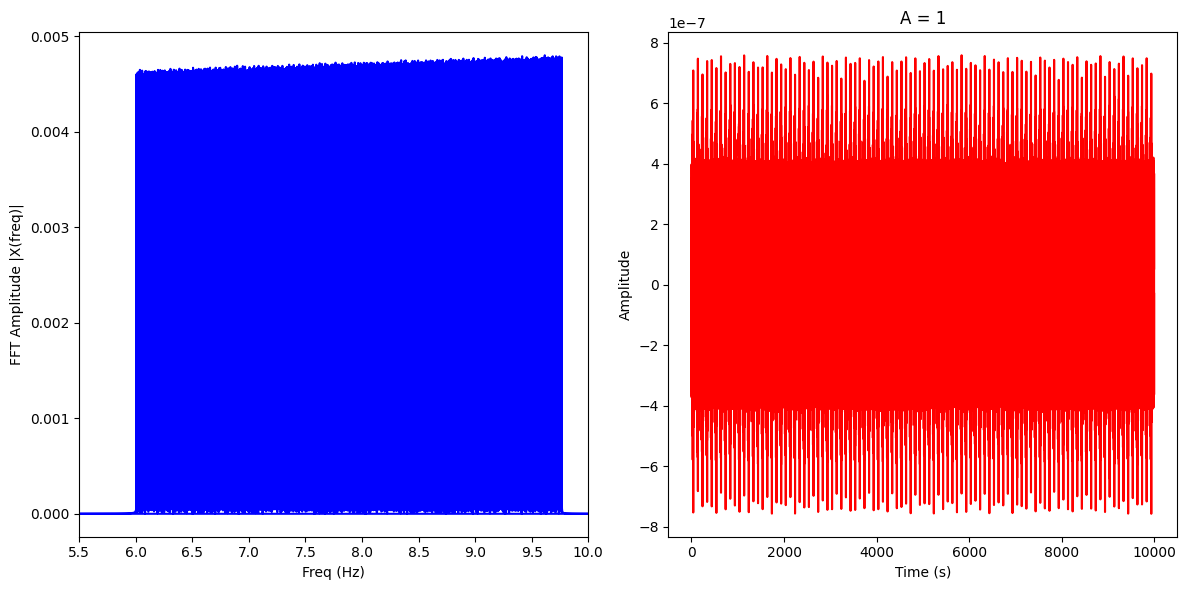

In [280]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq2, abs(amp2), 'b')#, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(5.5,10)

plt.subplot(122)
plt.plot(t2, amp22, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("A = 1")
plt.tight_layout()

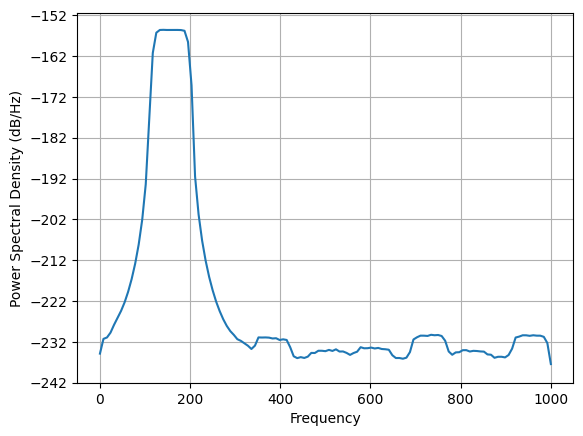

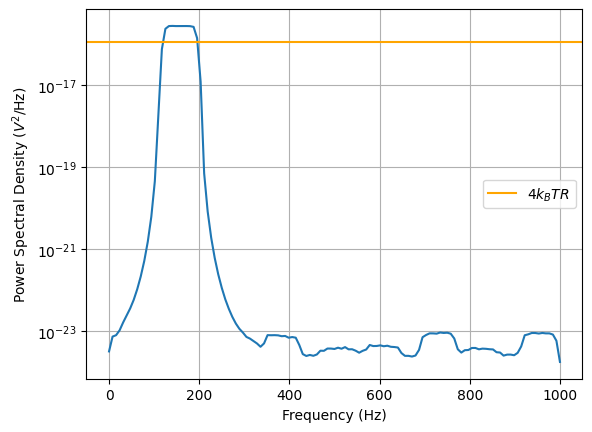

In [281]:
P, f = plt.psd(amp22, Fs=2e3)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
plt.legend()
plt.grid()
plt.show()

In [282]:
freqs, freq, amp, t, amp2 = band_limited_noise(w0, delta_f*10, samples=1.e6, samplerate=1.e3)

3770000.0it [02:17, 27454.84it/s]                                       


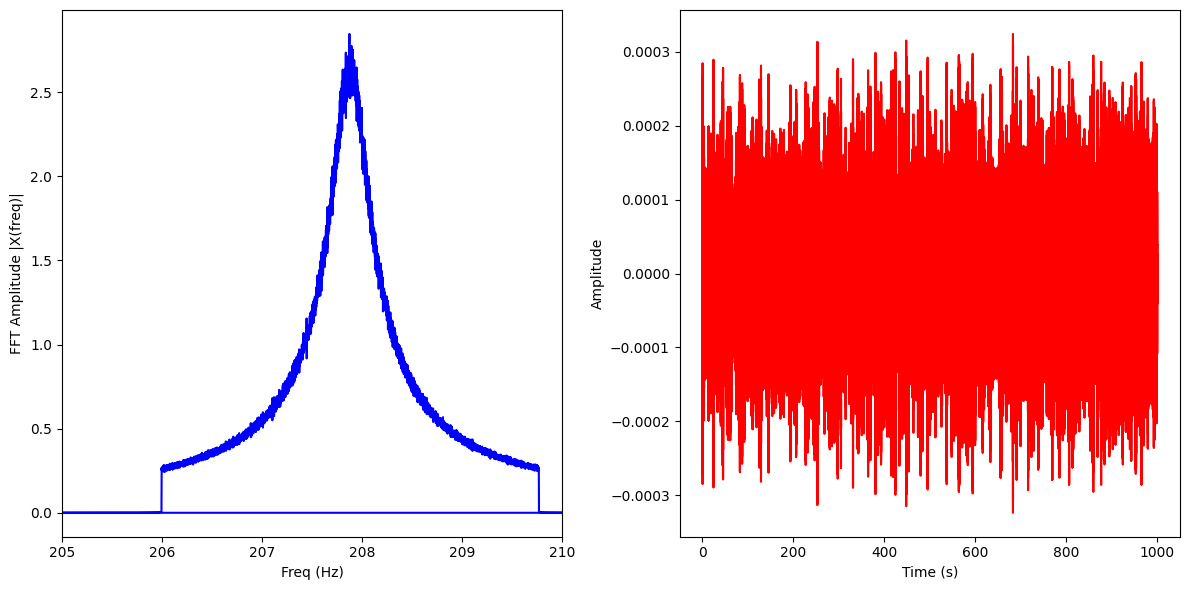

In [283]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq, abs(amp), 'b')#, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(205, 210)

plt.subplot(122)
plt.plot(t, amp2, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

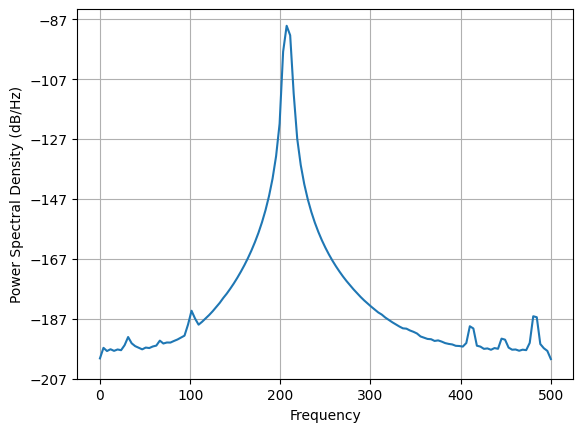

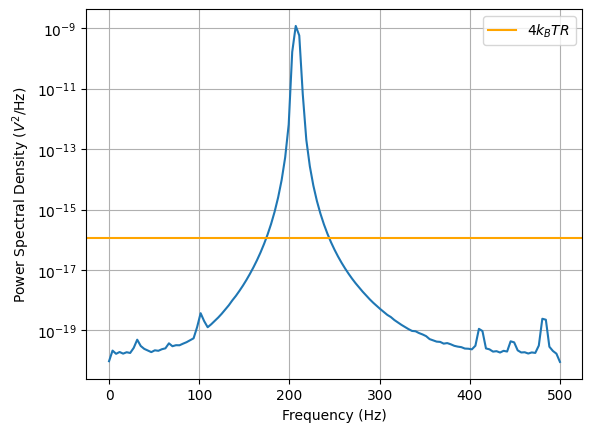

In [284]:
P, f = plt.psd(amp2, Fs=1e3)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

In [285]:
freqs, freq, amp, t, amp2 = band_limited_noise(w0, delta_f*100, samples=1.e6, samplerate=1e2)

37700000.0it [02:21, 265654.22it/s]                                       


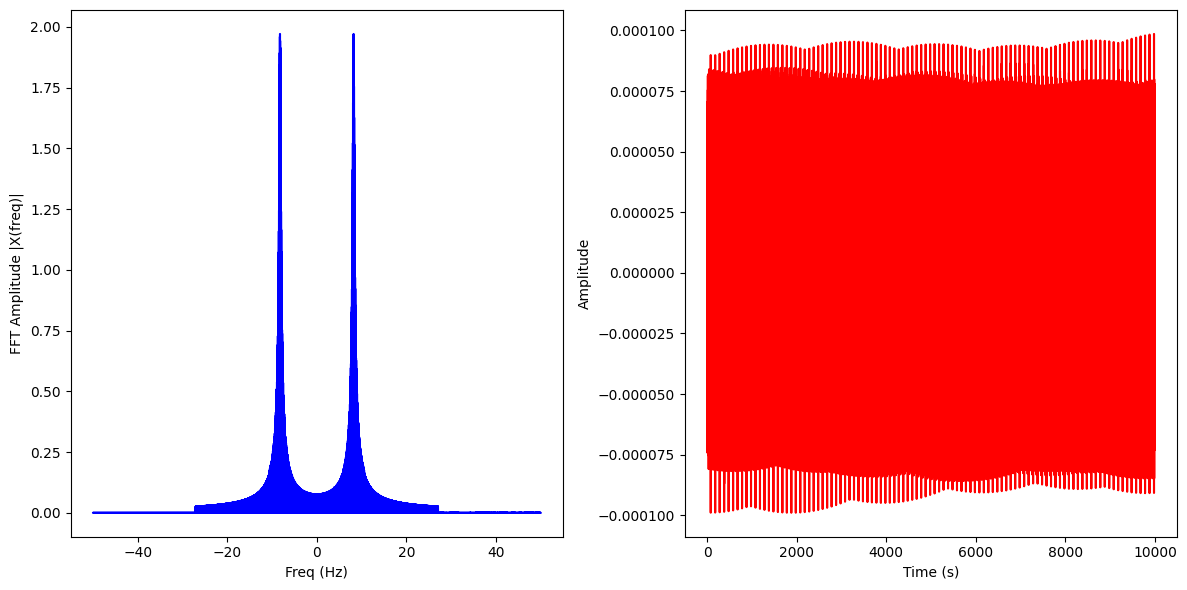

In [286]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq, abs(amp), 'b')#, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
##plt.xlim(0.058, 0.063)

plt.subplot(122)
plt.plot(t, amp2, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

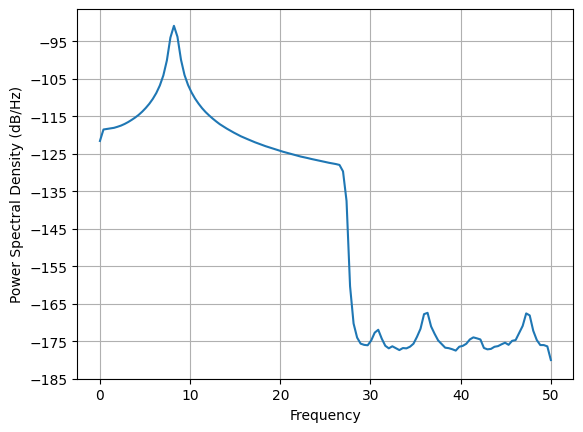

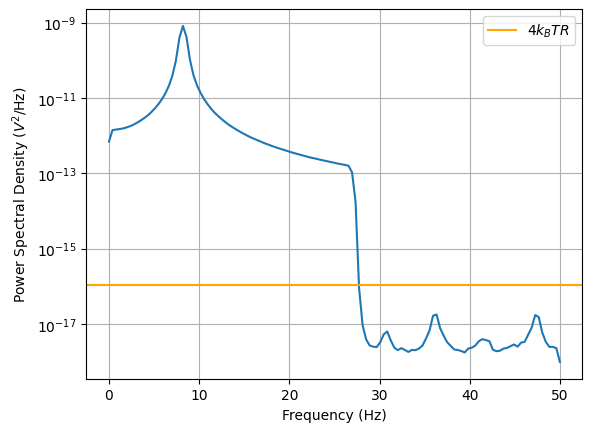

In [288]:
P, f = plt.psd(amp2, Fs=1e2)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

### Bandwidth = 1/dt and samplerate ~ 1e4

In [61]:
freqs3, freq3, amp3, t3, amp23 = band_limited_noise(w0, delta_f*10, samples=1.e6, samplerate=1e4)

18849600.0it [2:02:03, 2573.82it/s]                                         


In [228]:
# Supposedly faster but too memory consuming
# freqs3, freq3, amp3, t3, amp23 = band_limited_noise_sampled(w0, 1e13, samples=1.e6, samplerate=1e13, n_freq=1e13)

MemoryError: Unable to allocate 72.8 TiB for an array with shape (10000000000000,) and data type float64

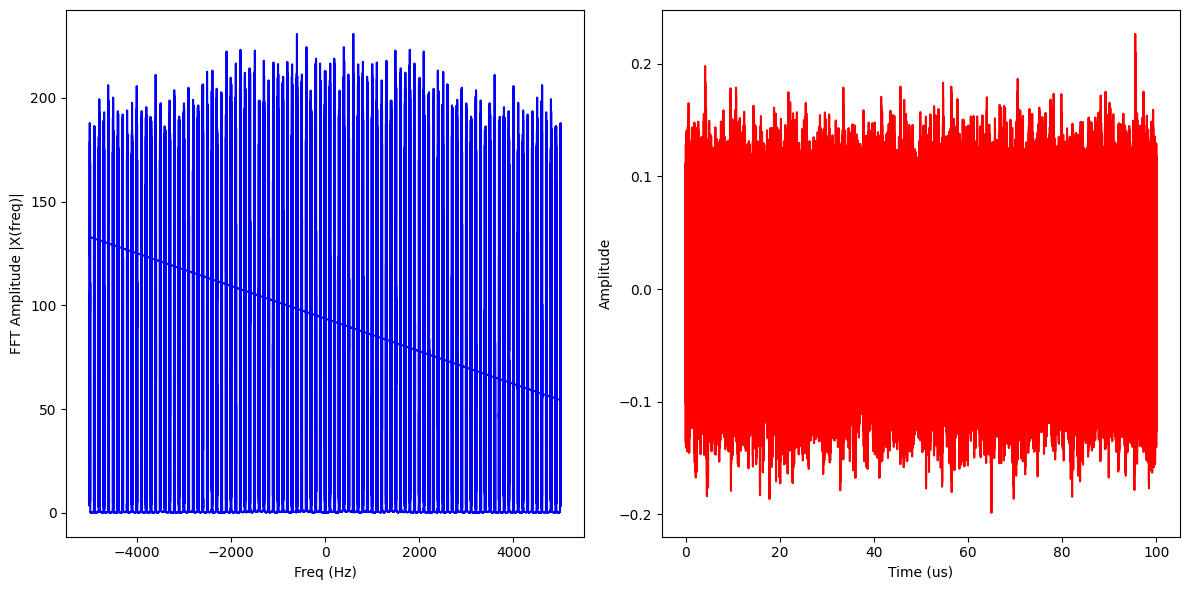

In [71]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq3, abs(amp3), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
#plt.xlim(-0.25e11, 0.25e11)

plt.subplot(122)
plt.plot(t3, amp23, 'r') # Note that I think there's some offs in scaling bc there's only 1e6 samples here
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.tight_layout()

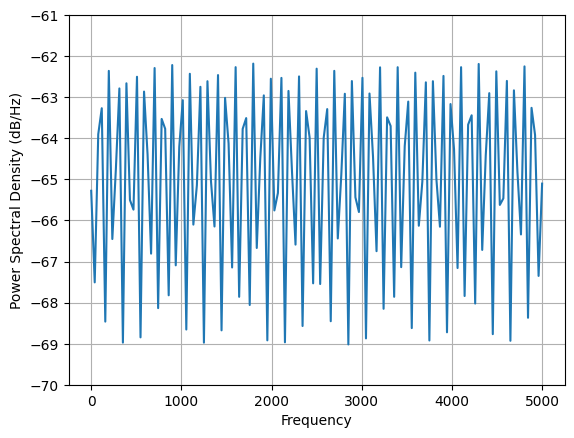

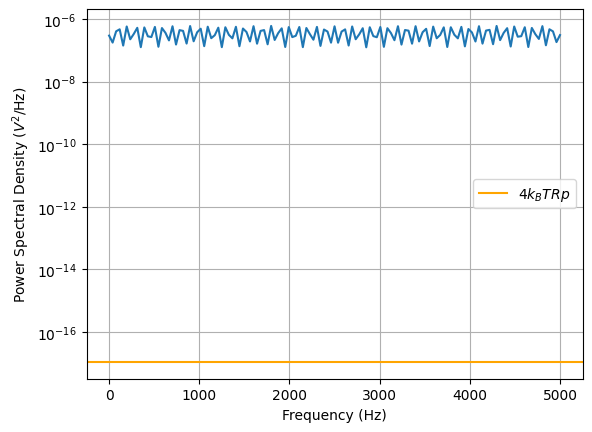

In [82]:
P, f = plt.psd(amp23, Fs=1e4)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*Rp, label=r'$4k_BTRp$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

### Comparisons

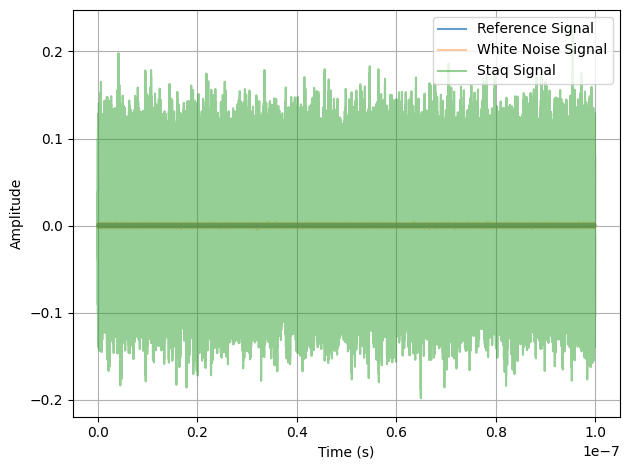

In [77]:
t_tot = 1e6 * 1e-13 # need to scale the time since there were only 1e6 samples generated from the previous code
U_rms = np.sqrt(4 * kB * temp_res * R / dt)
signal = np.random.normal(0, 0.4*U_rms, size = int(t_tot/dt))
t_amp0 = np.random.normal(0, U_rms, size = int(t_tot/dt))

t = np.linspace(0, t_tot, int(t_tot/dt))
plt.plot(t, signal, alpha=0.7, label='Reference Signal')
plt.plot(t, t_amp0, alpha=0.4, label='White Noise Signal')
plt.plot(t, amp23, alpha=0.5, label='Staq Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

### NOTE
This signal is larger than the $\Delta f=1/(2\pi dt)$ method, but this may be resolved by passing it through a filter. Still under investigation...

In [20]:
from esim import data_dir
import os

In [22]:
base_dir = os.path.join(data_dir, 'noise_ver5')
base_dir

'c:\\users\\electron\\downloads\\esim\\esim\\data\\noise_ver5'

In [23]:
for i in trange(10):
    f_amp0, f_amp, freq, t_amp, t, t_amp0 = rlc_noise(temp_res, R, L, C, 10e-6, dt)
    np.savez(os.path.join(base_dir, f'{i}.npz'), noise=t_amp)

100%|██████████| 10/10 [04:21<00:00, 26.19s/it]


In [135]:
base_dir = os.path.join(data_dir, 'noise_ver5.1')
os.makedirs(base_dir, exist_ok=True)
for i in trange(10):
    f_amp0, f_amp, freq, t_amp, t, t_amp0 = rlc_noise(temp_res, R, 1/q, w0, 10e-6, dt)
    np.savez(os.path.join(base_dir, f'{i}.npz'), noise=t_amp)

  0%|          | 0/10 [00:00<?, ?it/s]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 10%|█         | 1/10 [00:46<06:54, 46.07s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 20%|██        | 2/10 [01:30<06:02, 45.31s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 30%|███       | 3/10 [02:17<05:20, 45.86s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 40%|████      | 4/10 [03:02<04:32, 45.43s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 50%|█████     | 5/10 [03:47<03:46, 45.36s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 60%|██████    | 6/10 [04:32<03:01, 45.29s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 70%|███████   | 7/10 [05:17<02:15, 45.17s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 80%|████████  | 8/10 [06:01<01:29, 44.90s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


 90%|█████████ | 9/10 [06:47<00:45, 45.15s/it]

R: 5.00e+06 Ohm, L: 104777004.20 uH, C: 2.69e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.00025316455696202533, Bandwidth: 7.45e+11


100%|██████████| 10/10 [07:32<00:00, 45.25s/it]


### Checking Saved Noises

In [50]:
def noise_generator(parameters):
        noise_idx = 0
        remaining_noise = 0
        base_dir = os.path.join(data_dir, 'noise_ver5')
        while True:
            if remaining_noise == 0:
                noise = np.load(os.path.join(base_dir, f'{noise_idx}.npz'))['noise']
                remaining_noise = len(noise)
                noise = iter(noise)
                noise_idx += 1
                
            yield next(noise)
            remaining_noise -= 1

In [51]:
test_gen = noise_generator(None)

In [52]:
test_t, test_n = [], []
for i in trange(int(30e-6/dt)):
    n = next(test_gen)
    if i % 10000 == 1:
        test_t.append(i*dt)
        test_n.append(n)

100%|██████████| 300000000/300000000 [02:17<00:00, 2183116.39it/s]


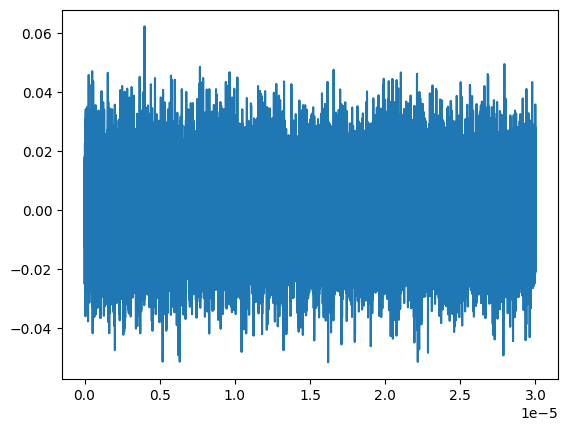

In [54]:
plt.plot(test_t, test_n)